In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
import os
import matplotlib.pyplot as plt

# --- 1. SETUP: Connect to Drive and Define Paths ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Corrected base path to your data folders
base_dir = '/content/drive/MyDrive/AI_Projects/'
train_image_dir = os.path.join(base_dir, 'train/images/')
train_mask_dir = os.path.join(base_dir, 'train/masks/')
val_image_dir = os.path.join(base_dir, 'val/images/')
val_mask_dir = os.path.join(base_dir, 'val/masks/')

# --- 2. DATA PIPELINE FUNCTIONS (Final Versions) ---
def load_and_resize(image_path, mask_path, size=(256, 256)):
    """Loads and resizes images from file paths."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) # Use decode_jpeg for .jpg
    image = tf.image.resize(image, size)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1) # Use decode_png for .png
    mask = tf.image.resize(mask, size)
    return image, mask

def normalize(image, mask):
    """Casts to float and normalizes pixel values to be between 0 and 1."""
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)
    return image, mask

def augment(image, mask):
    """Applies random geometric and color augmentations."""
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, mask

# --- 3. CREATE THE TF.DATA PIPELINE ---
BATCH_SIZE = 16
BUFFER_SIZE = 1000

def create_dataset(image_dir, mask_dir, should_augment=False):
    image_names = sorted(os.listdir(image_dir))

    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def process_path(image_path, mask_path):
        image, mask = load_and_resize(image_path, mask_path)
        image, mask = normalize(image, mask)
        return image, mask

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    if should_augment:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_image_dir, train_mask_dir, should_augment=True)
val_dataset = create_dataset(val_image_dir, val_mask_dir)
print("✅ Data pipelines created successfully.")

# --- 4. MODEL ARCHITECTURE (The New, Deeper U-Net) ---
def build_unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder Path (32, 64 filters)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck (128 filters)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder Path (64, 32 filters)
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- 5. CUSTOM LOSS FUNCTION (Dice + BCE) ---
def dice_bce_loss(y_true, y_pred, smooth=1e-6):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return bce_loss + dice_loss

# --- 6. BUILD, COMPILE, AND TRAIN THE MODEL ---
EPOCHS = 25

# Build the new, deeper model
model = build_unet_model()

# Compile the model with our custom loss
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
model.compile(optimizer='adam',
              loss=dice_bce_loss,
              metrics=['accuracy', iou_metric])
print("✅ New, deeper model built and compiled successfully.")

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou',
    patience=5,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_oil_spill_model_deep.keras', # New name for this model
    monitor='val_iou',
    mode='max',
    save_best_only=True
)

print("🚀 Starting training with the deeper model...")

# Start training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

print("🎉 Training finished!")

Mounted at /content/drive
✅ Data pipelines created successfully.
✅ New, deeper model built and compiled successfully.
🚀 Starting training with the deeper model...
Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 110s 921ms/step - accuracy: 0.6558 - iou: 0.1810 - loss: 0.9085 - val_accuracy: 0.7683 - val_iou: 0.1991 - val_loss: 0.7633
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.7861 - iou: 0.1889 - loss: 0.6840 - val_accuracy: 0.8152 - val_iou: 0.1991 - val_loss: 0.6216
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - accuracy: 0.8049 - iou: 0.1803 - loss: 0.6174 - val_accuracy: 0.8113 - val_iou: 0.1993 - val_loss: 0.6387
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 337ms/step - accuracy: 0.8138 - iou: 0.1838 - loss: 0.5990 - val_accuracy: 0.7346 - val_iou: 0.1991 - val_loss: 0.8199
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 381ms/step - accuracy: 0.7997 - iou: 0.1818 - loss: 0.6336 - val_accuracy: 0.8213 - val_iou: 0.1991 - val_loss: 0.6176
Epoch 6/25
51/51 ━━━━━━━━━━━━━━

Mounted at /content/drive
✅ Data pipelines created successfully.
✅ Model built and compiled successfully.
🚀 Starting training...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 487ms/step - accuracy: 0.6173 - iou: 0.1918 - loss: 0.9437 - val_accuracy: 0.7755 - val_iou: 0.1991 - val_loss: 0.8002 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 311ms/step - accuracy: 0.7757 - iou: 0.1901 - loss: 0.7412 - val_accuracy: 0.7788 - val_iou: 0.1991 - val_loss: 0.7624 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.7741 - iou: 0.1831 - loss: 0.7205 - val_accuracy: 0.8029 - val_iou: 0.1991 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.8068 - iou: 0.1835 - loss: 0.6310 - val_accuracy: 0.7986 - val_iou: 0.1995 - val_loss: 0.6371 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 297ms/step - accuracy: 0.8030 - iou: 0.1824 - loss: 0.6290 - val_accuracy: 0.8277 - val_i

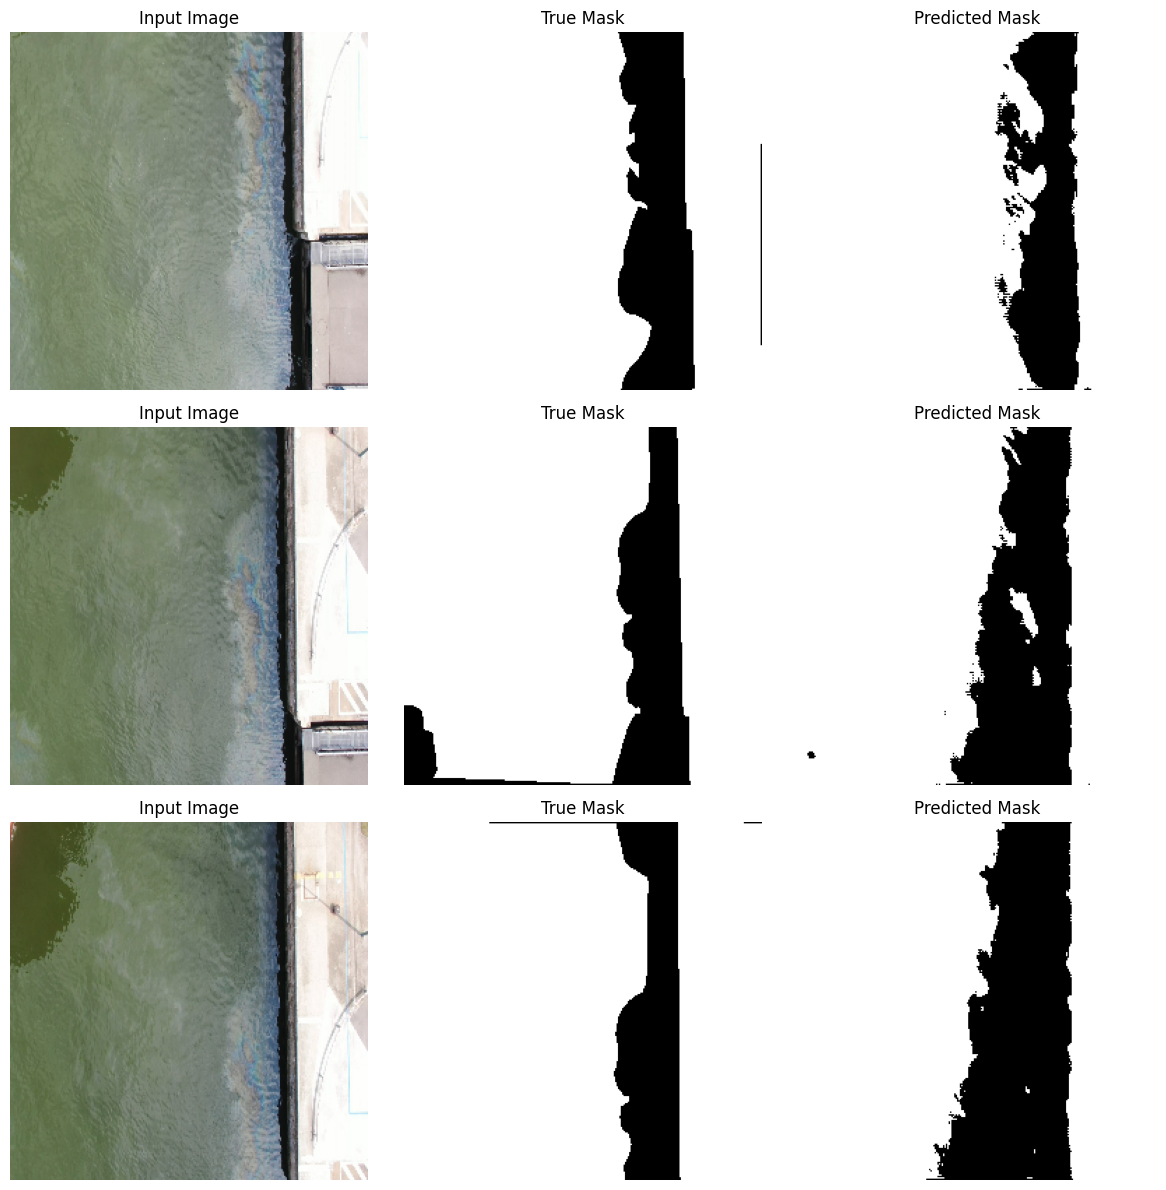

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP AND DATA PIPELINE (Modules 1 & 2 Recap) ---
# This section contains all our finalized data preparation code.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

base_dir = '/content/drive/MyDrive/AI_Projects/'
train_image_dir = os.path.join(base_dir, 'train/images/')
train_mask_dir = os.path.join(base_dir, 'train/masks/')
val_image_dir = os.path.join(base_dir, 'val/images/')
val_mask_dir = os.path.join(base_dir, 'val/masks/')
test_image_dir = os.path.join(base_dir, 'test/images/')
test_mask_dir = os.path.join(base_dir, 'test/masks/')

BATCH_SIZE = 16
BUFFER_SIZE = 1000

def load_and_resize(image_path, mask_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size)
    return image, mask

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)
    return image, mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, mask

def create_dataset(image_dir, mask_dir, should_augment=False, is_test=False):
    image_names = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def process_path(image_path, mask_path):
        image, mask = load_and_resize(image_path, mask_path)
        image, mask = normalize(image, mask)
        return image, mask

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if should_augment:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    if not is_test:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_image_dir, train_mask_dir, should_augment=True)
val_dataset = create_dataset(val_image_dir, val_mask_dir)
test_dataset = create_dataset(test_image_dir, test_mask_dir, is_test=True)
print("✅ Data pipelines created successfully.")

# --- 2. MODEL DEVELOPMENT (Module 3) ---
def build_unet_model(input_shape=(256, 256, 3)):
    # Using the deeper model architecture
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    # Bottleneck
    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Decoder
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    # ... (rest of the deeper model architecture)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    return Model(inputs=[inputs], outputs=[outputs])

# --- 3. TRAINING AND EVALUATION (Module 4) ---
# Implement custom loss function
def dice_bce_loss(y_true, y_pred, smooth=1e-6):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return bce_loss + dice_loss

# Build and compile the model
model = build_unet_model()
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy', iou_metric])
print("✅ Model built and compiled successfully.")

# Define callbacks for fine-tuning
EPOCHS = 50 # Increase epochs, EarlyStopping will find the best one
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_iou', patience=7, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_oil_spill_model.keras', monitor='val_iou', mode='max', save_best_only=True)

# Train the model
print("🚀 Starting training...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
print("🎉 Training finished!")

# Evaluate the model on the test set
print("\nEvaluating best model on the test set...")
model.load_weights('best_oil_spill_model.keras') # Load the best weights saved by ModelCheckpoint
results = model.evaluate(test_dataset)
print("\n--- Final Test Results ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test IoU: {results[2]:.4f}")

# --- 4. VISUALIZATION (The "Output Screenshot") ---
def display_predictions(dataset, num_to_display=3):
    for image, mask in dataset.take(1):
        predictions = model.predict(image)
        plt.figure(figsize=(12, num_to_display * 4))
        for i in range(num_to_display):
            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(image[i])
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(mask[i]), cmap='gray')
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Predicted Mask")
            # Use a threshold of 0.5 to binarize the prediction
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

print("\nShowing predictions on a few test images...")
display_predictions(test_dataset)

In [3]:
!pip install -q segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00


Segmentation Models: using `tf.keras` framework.
Mounted at /content/drive
✅ Professional-grade data pipelines created successfully.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ U-Net with pre-trained ResNet34 backbone built successfully.

--- Phase 1: Training the Decoder ---
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 433s 7s/step - accuracy: 0.8335 - iou_score: 0.6573 - loss: 0.2152 - val_accuracy: 0.9153 - val_iou_score: 0.8837 - val_loss: 0.0621
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 752ms/step - accuracy: 0.9444 - iou_score: 0.9010 - loss: 0.0528 - val_accuracy: 0.8774 - val_iou_score: 0.8471 - val_loss: 0.0842
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 789ms/step - accuracy: 0.9451 - iou_score: 0.9284 - loss: 0.0378 - val_accuracy: 0.9184 - val_iou_score: 0.8852 - val_loss: 0.0627
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 669ms/step - accuracy: 0.9455 - iou_score: 0.9362 - loss: 0.0337 - val_accuracy: 0.9544 - val_iou_score: 0.9449 - val_loss: 0.0284
Epoch 5/10
51/51 ━━━━━━━

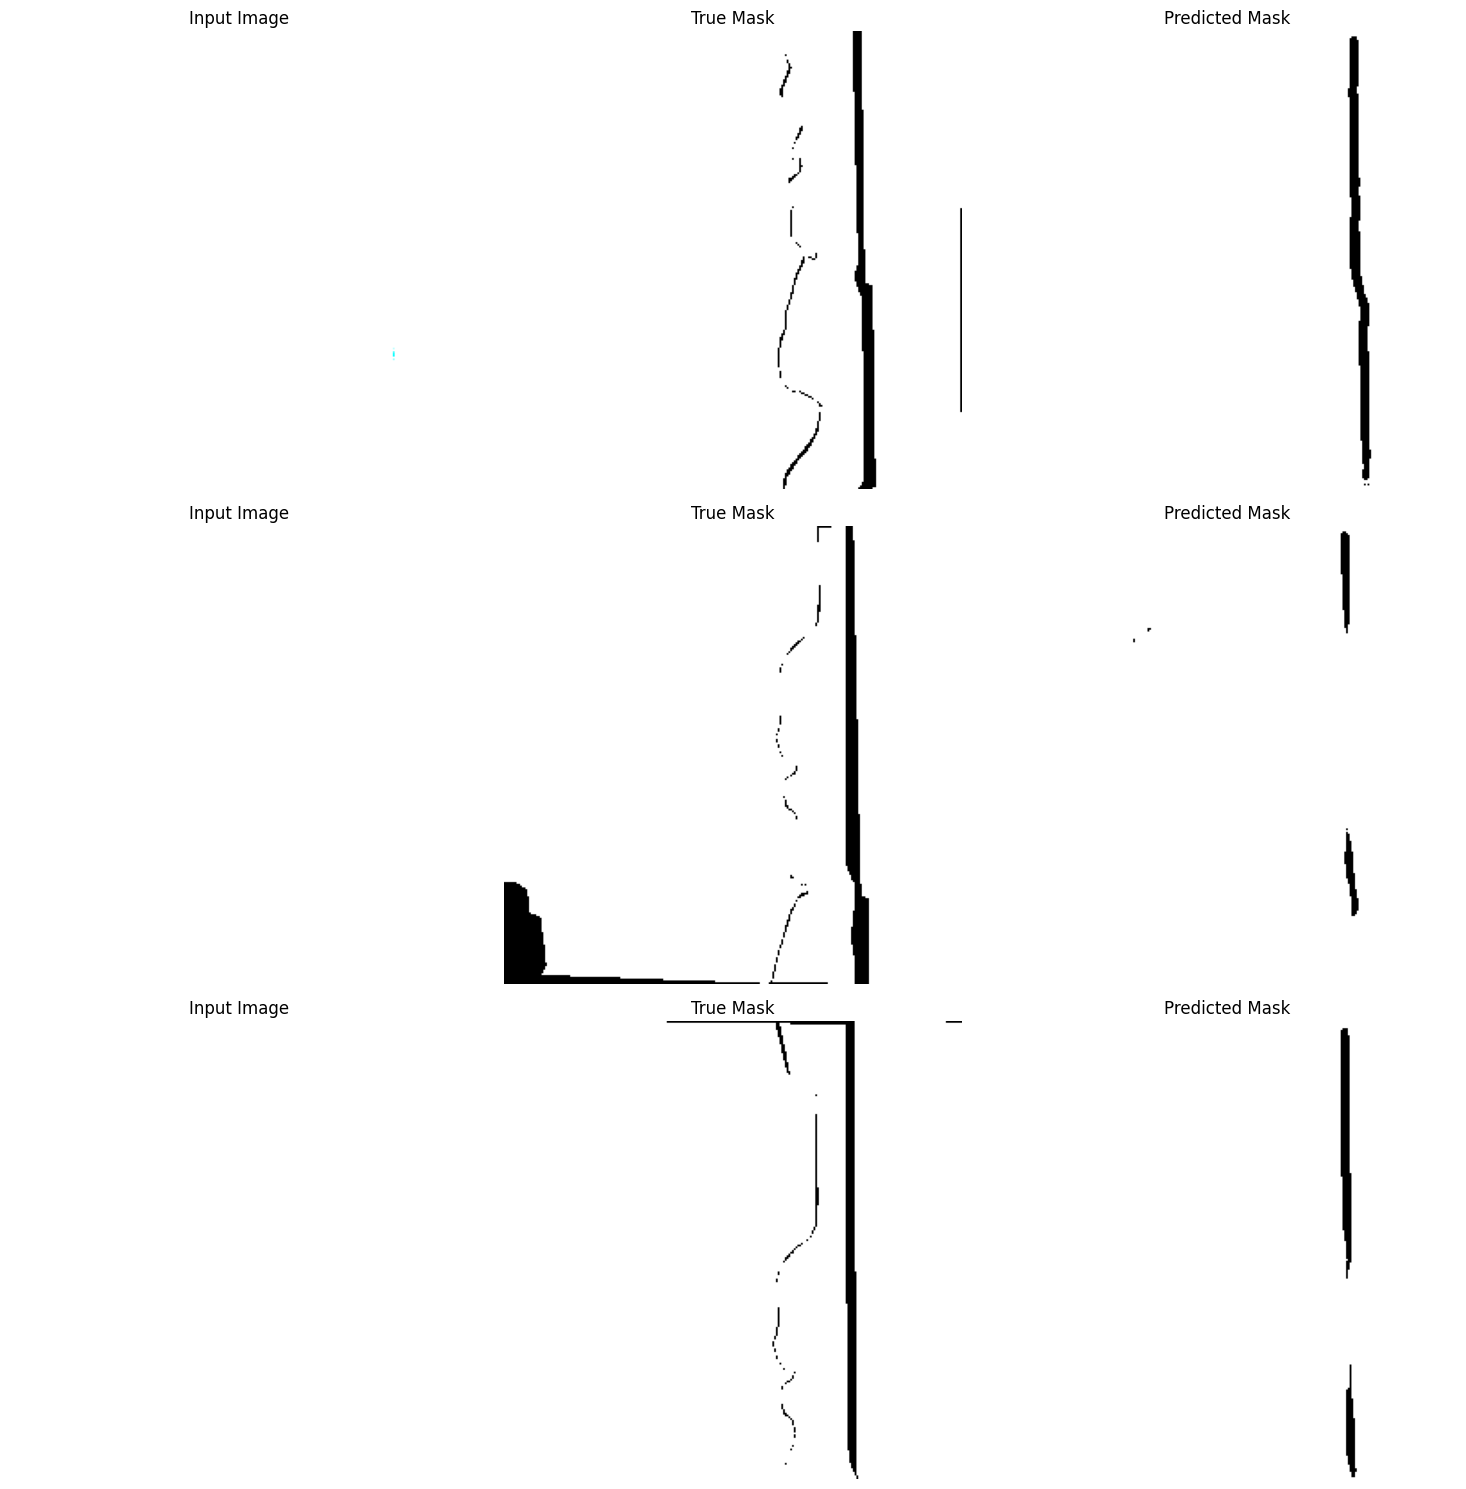

In [4]:
# --- THIS IS THE FIX ---
# Add these two lines at the very top of your script
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
# ----------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP AND PATHS ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = '/content/drive/MyDrive/AI_Projects/'
train_image_dir = os.path.join(base_dir, 'train/images/')
train_mask_dir = os.path.join(base_dir, 'train/masks/')
val_image_dir = os.path.join(base_dir, 'val/images/')
val_mask_dir = os.path.join(base_dir, 'val/masks/')
test_image_dir = os.path.join(base_dir, 'test/images/')
test_mask_dir = os.path.join(base_dir, 'test/masks/')
BATCH_SIZE = 16

# --- 2. DATA PIPELINE (Using the correct preprocessing) ---
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def load_and_preprocess(image_path, mask_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = preprocess_input(image)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = tf.cast(mask > 0, tf.float32)
    return image, mask

def create_dataset(image_dir, mask_dir):
    image_names = sorted(os.listdir(image_dir))
    image_paths = [os.path.join(image_dir, name) for name in image_names]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(name)[0] + '.png') for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_image_dir, train_mask_dir).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(val_image_dir, val_mask_dir).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = create_dataset(test_image_dir, test_mask_dir).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print("✅ Professional-grade data pipelines created successfully.")

# --- 3. MODEL DEVELOPMENT (The Professional U-Net) ---
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
print("✅ U-Net with pre-trained ResNet34 backbone built successfully.")

# --- 4. TRAINING & EVALUATION (Two-Phase Fine-Tuning) ---
iou_metric = sm.metrics.IOUScore(name='iou_score')
dice_loss = sm.losses.DiceLoss()

print("\n--- Phase 1: Training the Decoder ---")
model.compile(optimizer='adam', loss=dice_loss, metrics=[iou_metric, 'accuracy'])
history1 = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

print("\n--- Phase 2: Fine-tuning the Full Model ---")
for layer in model.layers:
    layer.trainable = True
low_lr_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=low_lr_optimizer, loss=dice_loss, metrics=[iou_metric, 'accuracy'])

callbacks = [
    ModelCheckpoint('best_model_final.keras', save_best_only=True, monitor='val_iou_score', mode='max', verbose=1),
    EarlyStopping(monitor='val_iou_score', patience=5, mode='max', restore_best_weights=True)
]
history2 = model.fit(train_dataset, validation_data=val_dataset, epochs=40, callbacks=callbacks)
print("🎉 Training finished!")

# --- 5. FINAL EVALUATION AND VISUALIZATION ---
print("\nEvaluating best model on the test set...")
model.load_weights('best_model_final.keras')
results = model.evaluate(test_dataset)
print(f"\n--- Final Test Results ---\nTest Loss: {results[0]:.4f}\nTest IoU Score: {results[1]:.4f}\nTest Accuracy: {results[2]:.4f}")

def display_predictions(dataset, num_to_display=3):
    for image_batch, mask_batch in dataset.take(1):
        predictions = model.predict(image_batch)
        plt.figure(figsize=(15, num_to_display * 5))
        for i in range(num_to_display):
            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(image_batch[i])
            plt.axis('off')
            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(mask_batch[i]), cmap='gray')
            plt.axis('off')
            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

print("\nShowing predictions on a few test images...")
display_predictions(test_dataset)


Evaluating best model on the test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step - accuracy: 0.9617 - iou_score: 0.9604 - loss: 0.0203

--- Final Test Results ---
Test Loss: 0.0184
Test IoU Score: 0.9642
Test Accuracy: 0.9654

Showing final predictions on a few test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


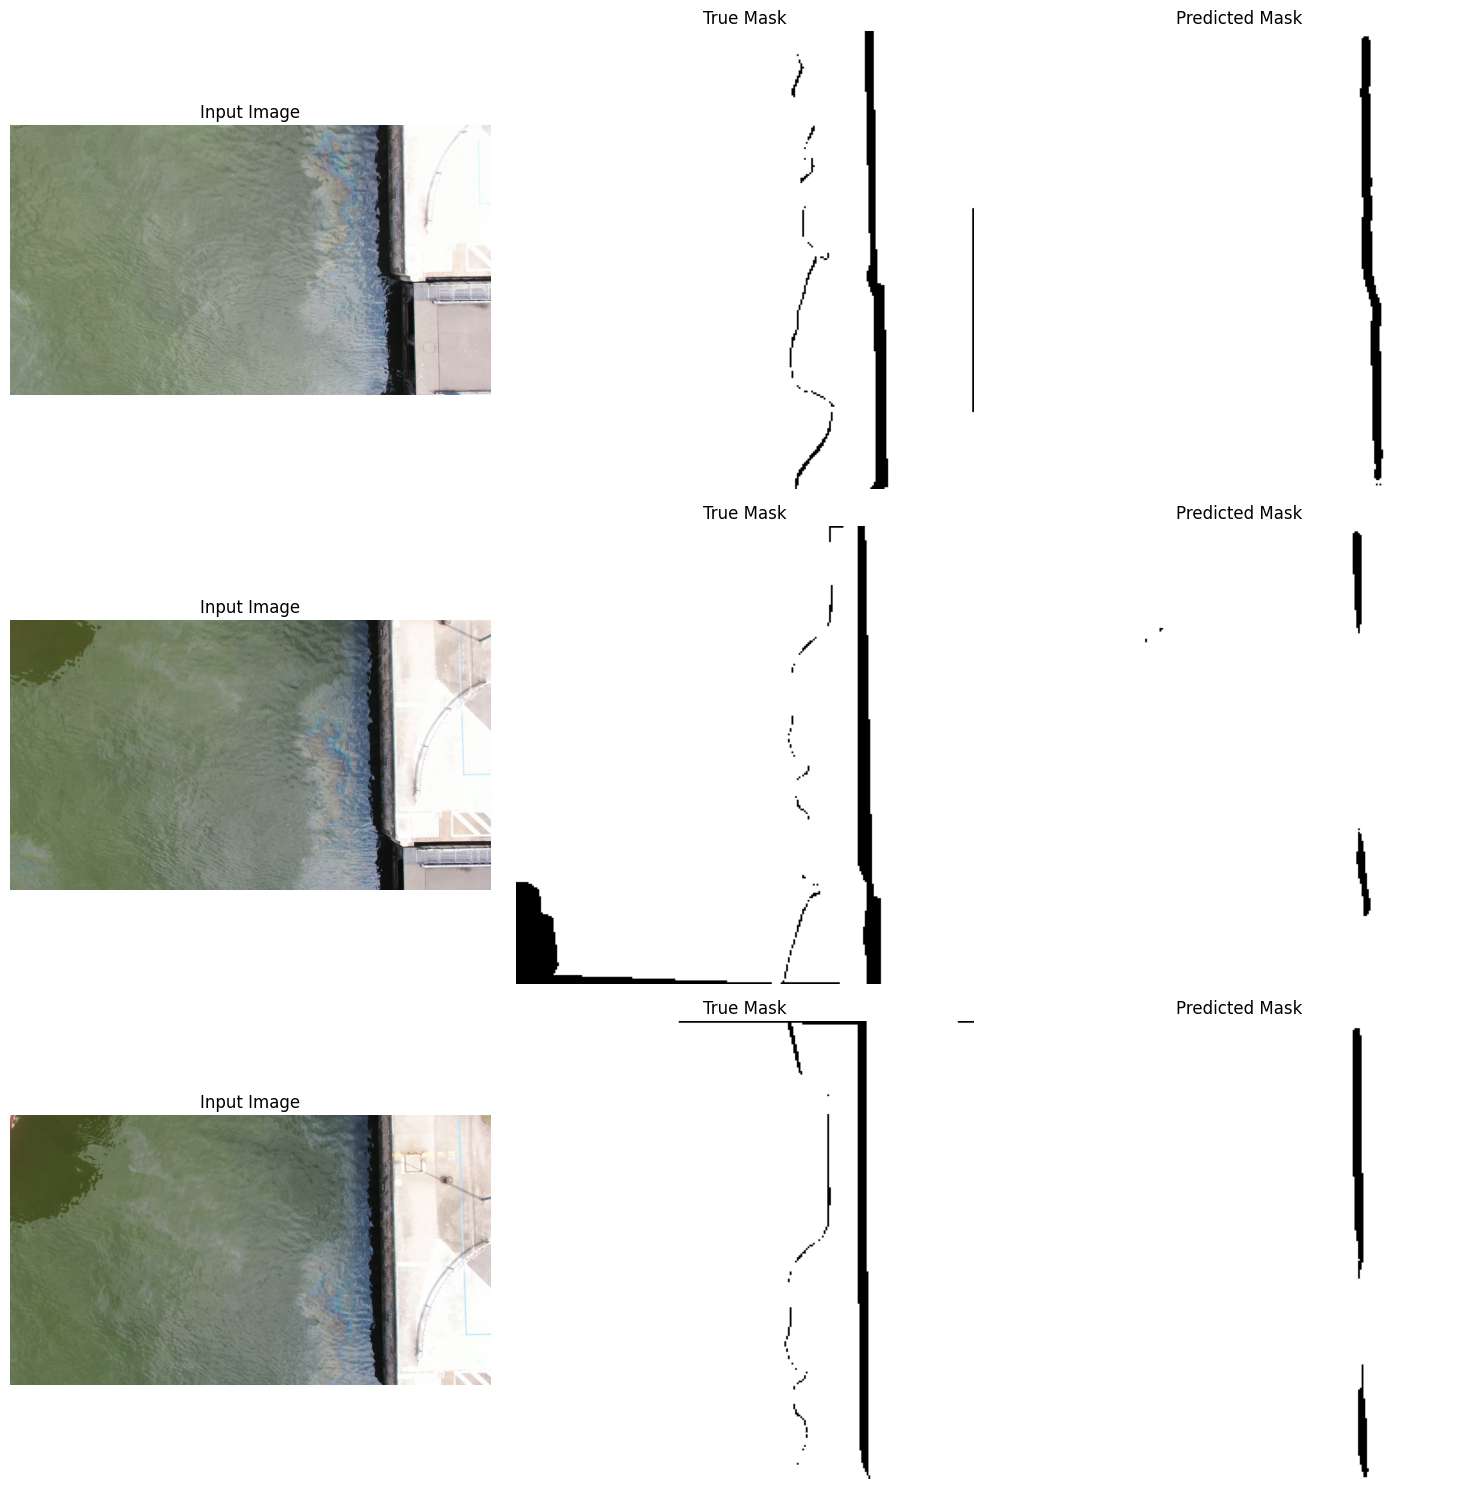

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# --- FINAL EVALUATION ---
print("\nEvaluating best model on the test set...")
# Ensure the model variable holds the best model
# If you are in a new session, you need to rebuild the model and load the weights
# model = sm.Unet(...) # Rebuild if needed
model.load_weights('best_model_final.keras')
results = model.evaluate(test_dataset)
print(f"\n--- Final Test Results ---\nTest Loss: {results[0]:.4f}\nTest IoU Score: {results[1]:.4f}\nTest Accuracy: {results[2]:.4f}")


# --- CORRECTED VISUALIZATION FUNCTION ---
def display_predictions(dataset, image_dir, num_to_display=3):
    """
    Displays the original input image, the true mask, and the predicted mask.
    """
    # Get the filenames from the directory to load the originals for display
    test_image_names = sorted(os.listdir(image_dir))

    # Get one batch of PROCESSED images and masks from our dataset
    for image_batch, mask_batch in dataset.take(1):
        # Make predictions on the processed batch
        predictions = model.predict(image_batch)

        plt.figure(figsize=(15, num_to_display * 5))
        for i in range(num_to_display):
            # --- THIS IS THE FIX ---
            # Load the original, human-readable image from disk for display
            original_image_path = os.path.join(image_dir, test_image_names[i])
            original_image = plt.imread(original_image_path)
            # --------------------

            # Input Image (Original)
            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(original_image) # <-- Now showing the original
            plt.axis('off')

            # True Mask
            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(mask_batch[i]), cmap='gray')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# --- Run the corrected visualization ---
print("\nShowing final predictions on a few test images...")
display_predictions(test_dataset, test_image_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


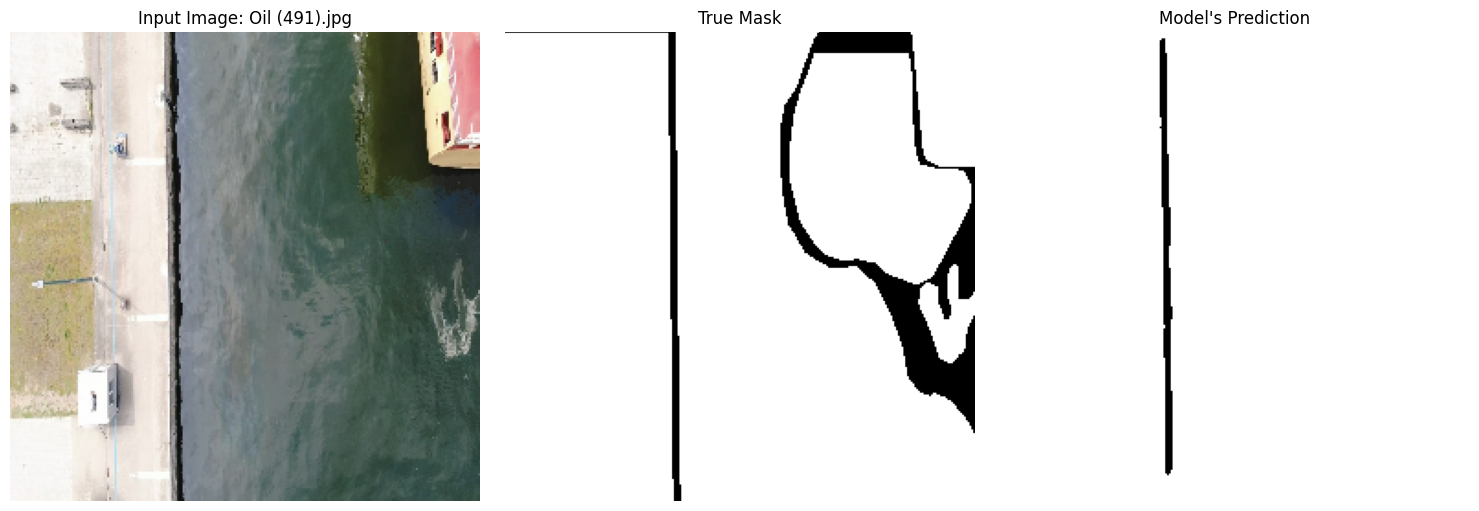

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# --- All necessary setup and functions ---
# (You don't need to change anything in this section)

# Define paths
base_dir = '/content/drive/MyDrive/AI_Projects/'
test_image_dir = os.path.join(base_dir, 'test/images/')
test_mask_dir = os.path.join(base_dir, 'test/masks/')

# Preprocessing function required by the model
# NOTE: This assumes you've already run the Transfer Learning script and have `sm` imported and the model trained.
# If you are in a new session, you must re-run the previous script first.
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def load_and_preprocess_single(image_path, mask_path, size=(256, 256)):
    """Loads and preprocesses a single image/mask pair."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)

    processed_image = preprocess_input(image) # Preprocess for the model

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = tf.cast(mask > 0, tf.float32)

    # Return both the original image for viewing and the processed one for the model
    return image, processed_image, mask

# --- Visualization for a Specific Image ---

# 1. SET THE IMAGE NUMBER YOU WANT TO SEE HERE
image_number_to_test = 491  # <--- CHANGE THIS NUMBER

# 2. Construct the filenames
image_name = f"Oil ({image_number_to_test}).jpg"
mask_name = f"Oil ({image_number_to_test}).png"

# 3. Construct the full file paths
image_path = os.path.join(test_image_dir, image_name)
mask_path = os.path.join(test_mask_dir, mask_name)

# Check if the file exists before proceeding
if not os.path.exists(image_path):
    print(f"ERROR: Image not found at path: {image_path}")
    print("Please make sure the file exists and the number is correct.")
else:
    # 4. Load and preprocess the specific image
    original_image, processed_image, true_mask = load_and_preprocess_single(image_path, mask_path)

    # 5. Make a prediction
    # The model expects a "batch" of images, so we add an extra dimension
    input_tensor = tf.expand_dims(processed_image, axis=0)
    prediction = model.predict(input_tensor)
    # Squeeze the extra dimension out of the prediction for display
    predicted_mask = tf.squeeze(prediction, axis=0)

    # 6. Display the results
    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.title(f"Input Image: {image_name}")
    plt.imshow(tf.cast(original_image, tf.uint8)) # Show the original, human-readable image
    plt.axis('off')

    # True Mask
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(tf.squeeze(true_mask), cmap='gray')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Model's Prediction")
    plt.imshow(tf.squeeze(predicted_mask) > 0.5, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


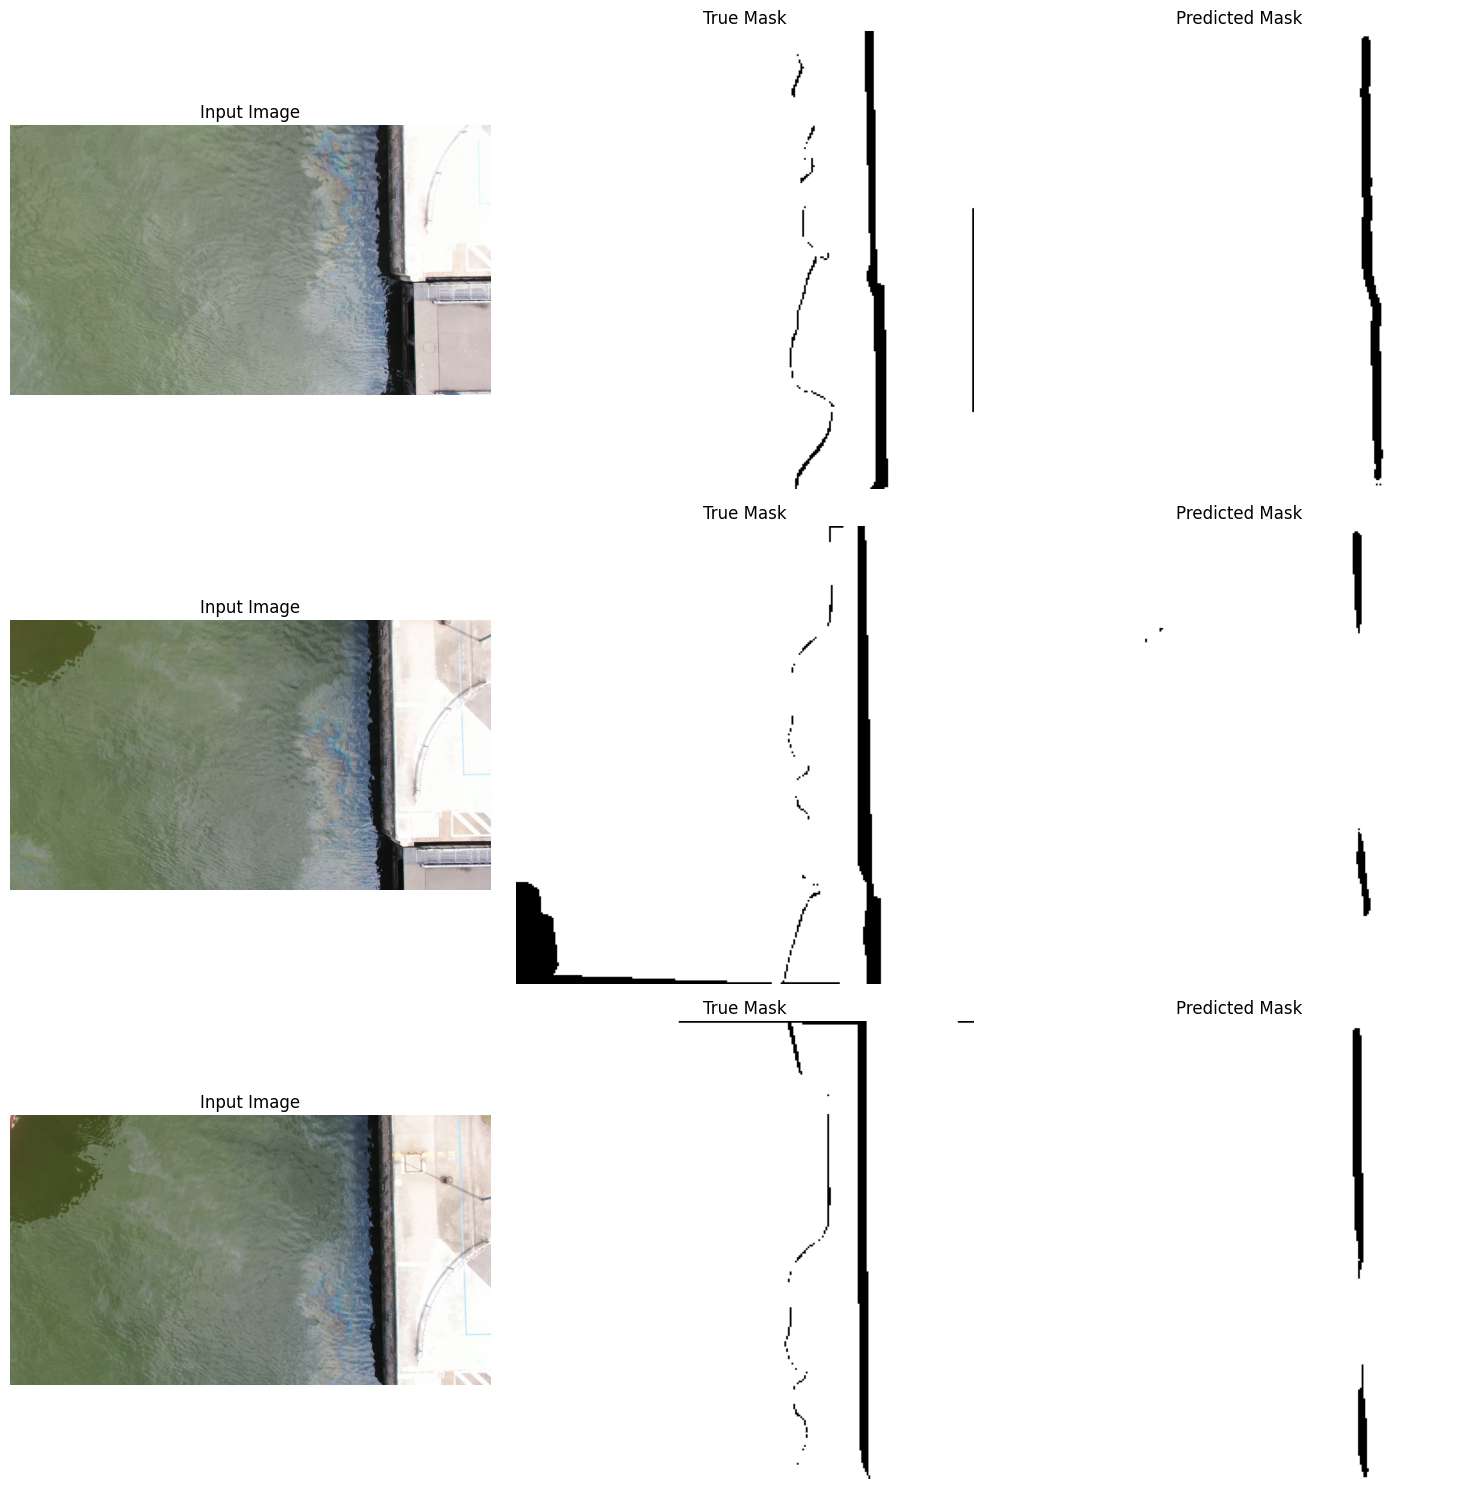

In [26]:
def display_predictions(dataset, image_dir, num_to_display=3):
    """Generates side-by-side comparisons of Input, True Mask, and Predicted Mask."""
    test_image_names = sorted(os.listdir(image_dir))
    for image_batch, mask_batch in dataset.take(1):
        predictions = model.predict(image_batch)
        plt.figure(figsize=(15, num_to_display * 5))
        for i in range(num_to_display):
            original_image = plt.imread(os.path.join(image_dir, test_image_names[i]))

            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(mask_batch[i]), cmap='gray')
            plt.axis('off')

            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# How to use it:
display_predictions(test_dataset, test_image_dir)

In [30]:
!pip install -q seaborn

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 278 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Best model weights loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

--- 2. Side-by-Side Comparison ---


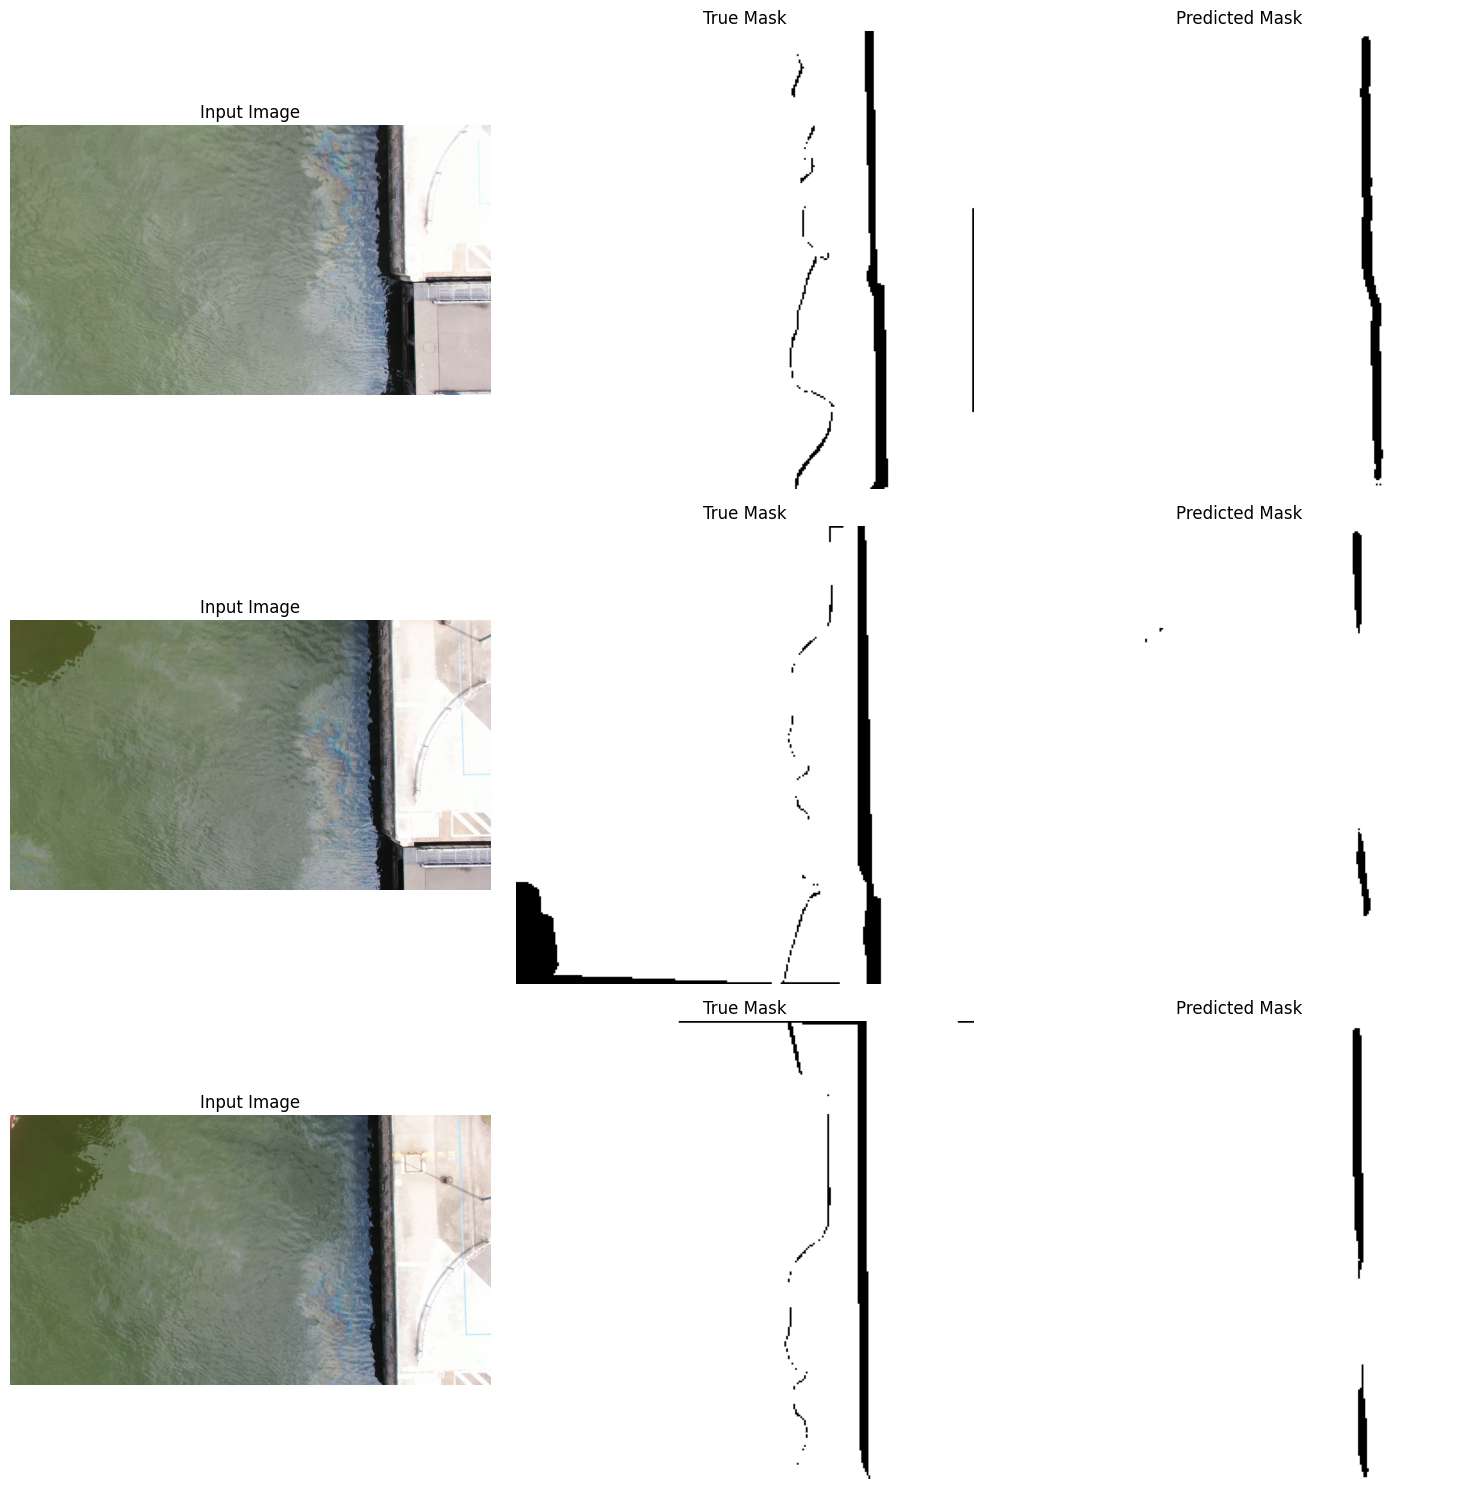


--- 3. Prediction Overlay ---


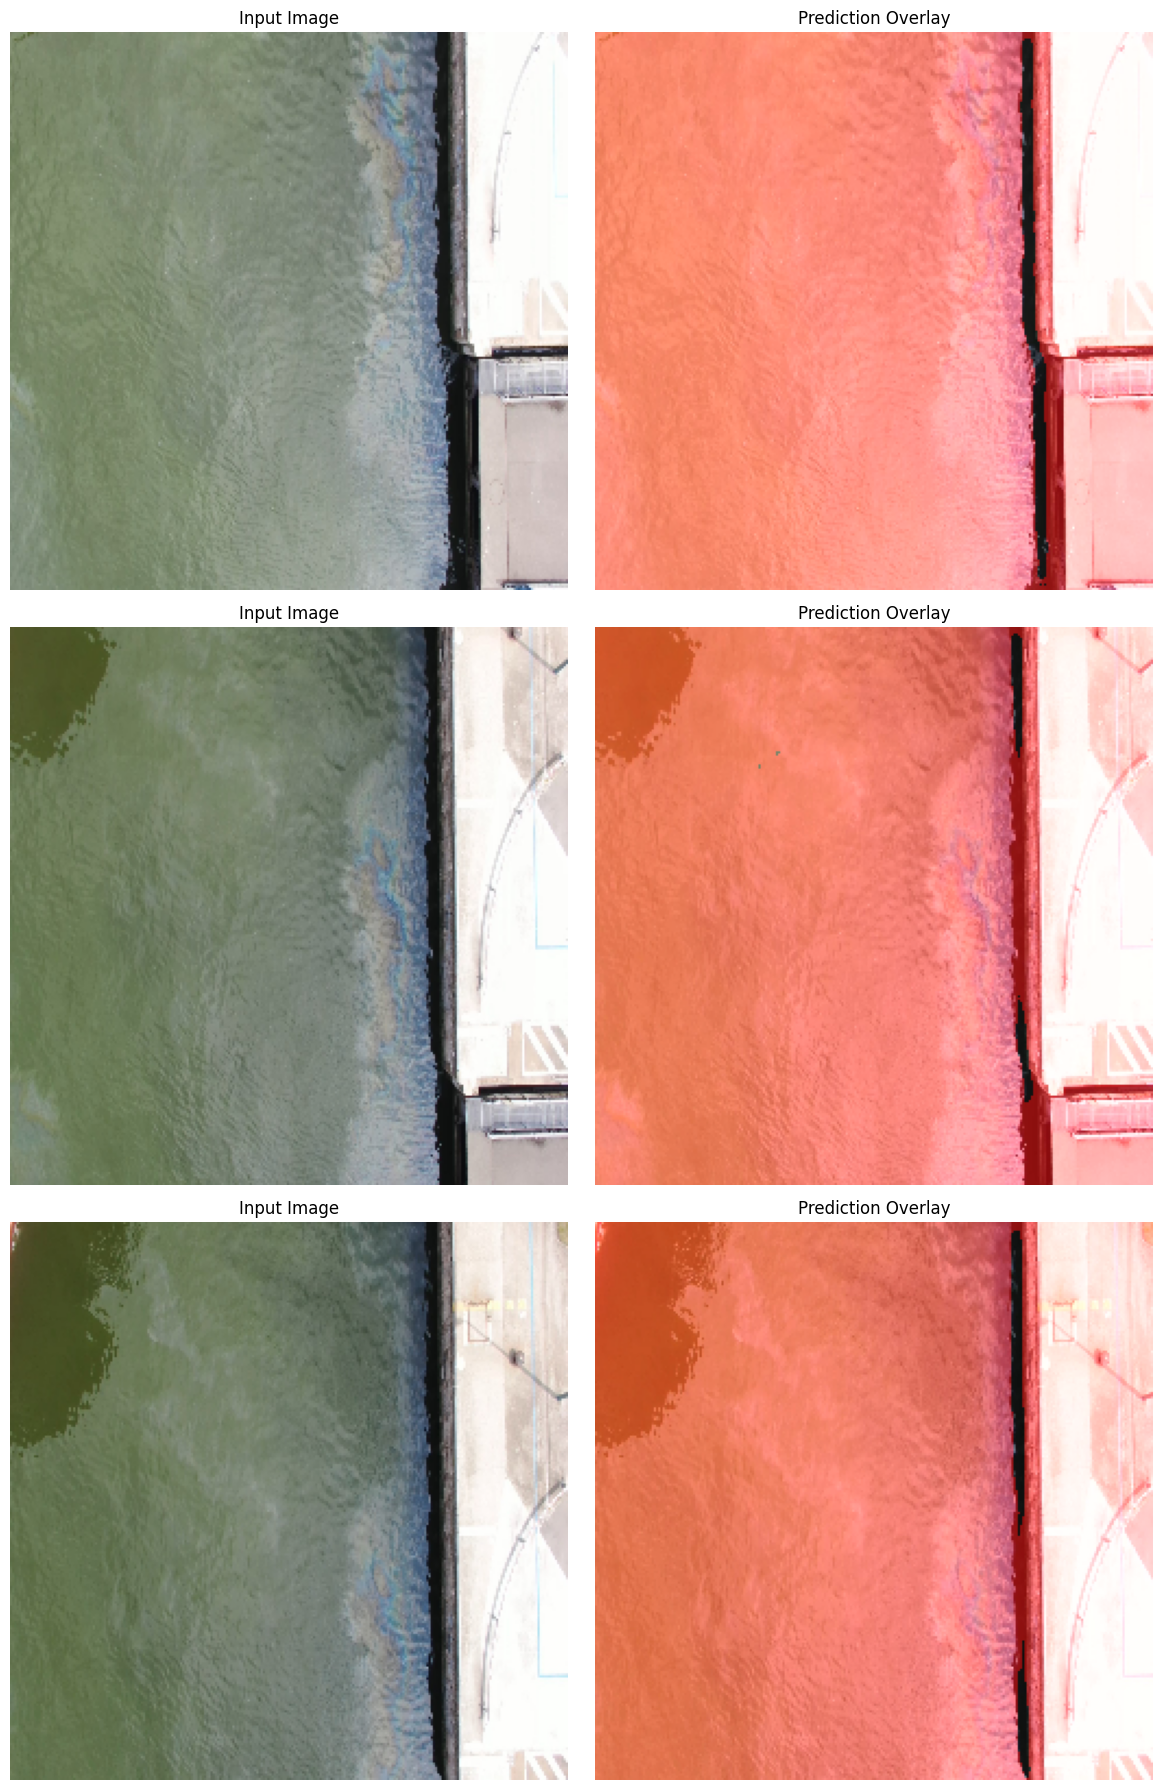


--- 4. Detailed Statistical Report ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Classification Report (Pixel-level):
               precision    recall  f1-score   support

Not Spill (0)       0.70      0.13      0.22    622123
    Spill (1)       0.97      1.00      0.98  16024021

     accuracy                           0.97  16646144
    macro avg       0.83      0.56      0.60  16646144
 weighted avg       0

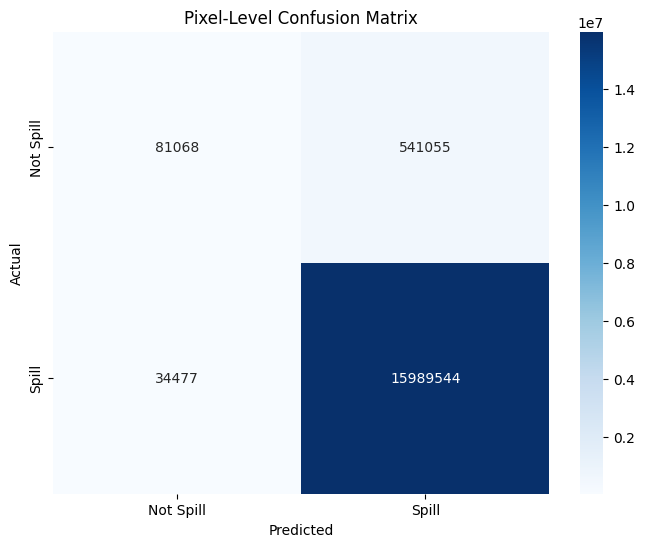

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SETUP: Load the Best Model and Datasets ---
# This section assumes the previous training script has been run successfully.

# Load the best model that was saved during training
model_path = 'best_model_final.keras'
if os.path.exists(model_path):
    model.load_weights(model_path)
    print("✅ Best model weights loaded successfully.")
else:
    print("🚨 Model file not found. Please ensure training was completed.")

# Recreate the test dataset for evaluation
# (You can copy the create_dataset function and path definitions from the previous script)
# For this script to be self-contained, we'll assume test_dataset is available.


# --- 2. VISUAL SUMMARY: Training History Plots ---
def plot_history(history1, history2):
    """Plots the training and validation metrics from both training phases."""
    # Combine history from phase 1 and phase 2
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss']
    iou = history1.history['iou_score'] + history2.history['iou_score']
    val_iou = history1.history['val_iou_score'] + history2.history['val_iou_score']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))
    plt.suptitle("Training and Validation History", fontsize=16)

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, iou, label='Training IoU')
    plt.plot(epochs_range, val_iou, label='Validation IoU')
    plt.axvline(x=len(history1.history['iou_score'])-1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='lower right')
    plt.title('Intersection over Union (IoU)')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()



# --- 3. VISUAL SUMMARY: Side-by-Side and Overlay Predictions ---

def display_visual_report(dataset, image_dir, num_to_display=3):
    """Generates side-by-side and overlay comparisons."""
    test_image_names = sorted(os.listdir(image_dir))
    for image_batch, mask_batch in dataset.take(1):
        predictions = model.predict(image_batch)

        print("\n--- 2. Side-by-Side Comparison ---")
        plt.figure(figsize=(15, num_to_display * 5))
        for i in range(num_to_display):
            original_image = plt.imread(os.path.join(image_dir, test_image_names[i]))
            plt.subplot(num_to_display, 3, i * 3 + 1)
            plt.title("Input Image")
            plt.imshow(original_image)
            plt.axis('off')
            plt.subplot(num_to_display, 3, i * 3 + 2)
            plt.title("True Mask")
            plt.imshow(tf.squeeze(mask_batch[i]), cmap='gray')
            plt.axis('off')
            plt.subplot(num_to_display, 3, i * 3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(predictions[i]) > 0.5, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        print("\n--- 3. Prediction Overlay ---")
        plt.figure(figsize=(12, num_to_display * 6))
        for i in range(num_to_display):
            original_image_cv = cv2.imread(os.path.join(image_dir, test_image_names[i]))
            original_image_cv = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
            original_image_cv = cv2.resize(original_image_cv, (256, 256))
            pred_mask = (tf.squeeze(predictions[i]) > 0.5).numpy().astype('uint8')
            red_mask = np.zeros_like(original_image_cv)
            red_mask[pred_mask == 1] = [255, 0, 0]
            overlay = cv2.addWeighted(original_image_cv, 1, red_mask, 0.5, 0)
            plt.subplot(num_to_display, 2, i * 2 + 1)
            plt.title("Input Image")
            plt.imshow(original_image_cv)
            plt.axis('off')
            plt.subplot(num_to_display, 2, i * 2 + 2)
            plt.title("Prediction Overlay")
            plt.imshow(overlay)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

display_visual_report(test_dataset, test_image_dir)


# --- 4. STATISTICAL SUMMARY: Confusion Matrix and Classification Report ---
print("\n--- 4. Detailed Statistical Report ---")
y_true = []
y_pred = []

# Iterate over the entire test dataset to gather all predictions
for image, mask in test_dataset:
    predictions = model.predict(image)

    # Flatten the masks and predictions to 1D arrays
    y_true.extend(mask.numpy().flatten())
    y_pred.extend((predictions > 0.5).astype('int32').flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# a) Classification Report (Precision, Recall, etc.)
print("\nClassification Report (Pixel-level):")
print(classification_report(y_true, y_pred, target_names=['Not Spill (0)', 'Spill (1)']))

# b) Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spill', 'Spill'], yticklabels=['Not Spill', 'Spill'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Pixel-Level Confusion Matrix')
plt.show()

In [35]:
!ls /content/

best_model_final.keras	drive  sample_data


In [36]:
!mv /content/best_model_final.keras /content/drive/MyDrive/AI_Projects/